In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from numpy import nan as NA


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# P1 Carga y Limpieza de datos

### 1. Carga

Adjuntamos df.head() al final de cada cambio importante para vizualizar como se va modificando

In [0]:
#Carga de los datos


df_all_13 = pd.read_csv("/content/drive/My Drive/data/raw/w13/metrocuadrado_all_w13.csv", engine='python')
df_furnished_13 = pd.read_csv("/content/drive/My Drive/data/raw/w13/metrocuadrado_all_w13.csv", engine='python')
df_all_14 = pd.read_csv("/content/drive/My Drive/data/raw/w14/metrocuadrado_all_w14.csv", engine='python')
df_furnished_14 = pd.read_csv("/content/drive/My Drive/data/raw/w14/metrocuadrado_furnished_w14.csv", engine='python')
df_all_15 = pd.read_csv("/content/drive/My Drive/data/raw/w15/metrocuadrado_all_w15.csv", engine='python')
df_furnished_15 = pd.read_csv("/content/drive/My Drive/data/raw/w15/metrocuadrado_furnished_w15.csv", engine='python')
df_all_16 = pd.read_csv("/content/drive/My Drive/data/raw/w16/metrocuadrado_all_w16.csv", engine='python')
df_furnished_16 = pd.read_csv("/content/drive/My Drive/data/raw/w16/metrocuadrado_furnished_w16.csv", engine='python')
df_all_17 = pd.read_csv("/content/drive/My Drive/data/raw/w17/metrocuadrado_all_w17.csv", engine='python')
df_furnished_17 = pd.read_csv("/content/drive/My Drive/data/raw/w17/metrocuadrado_furnished_w17.csv", engine='python')


In [4]:
#Agregamos variable categórica que diga si viene o no de un archivo "furnished"

df_all_13['furnished']=0
df_all_14['furnished']=0
df_all_15['furnished']=0
df_all_16['furnished']=0
df_all_17['furnished']=0
df_furnished_13['furnished']=1
df_furnished_14['furnished']=1
df_furnished_15['furnished']=1
df_furnished_16['furnished']=1
df_furnished_17['furnished']=1


#generamos un sólo DataFrame

frames = [df_all_13, df_furnished_13, df_all_14, df_furnished_14, df_all_15, df_furnished_15, df_all_16, df_furnished_16, df_all_17, df_furnished_17]

df = pd.concat(frames)
df1 = df

#Eliminamos filas duplicadas

df = df.drop_duplicates(['property_type|rent_type|location', 'price', 'n_rooms', 'n_bath',
       'surface', 'details', 'url', 'metrocuadrado_index'])

#Reindexamos y ordenamos para mejorar la eficiencia

df = df.reset_index(drop=True)
df.sort_index(inplace=True)

#¿cuantas filas furnished no estaban repetidas?, serán las que venían de un archivo furnished y no fueron eliminadas
#al borrar los duplicados

print("El número de filas que venían de Furnished no repetidas es",len(df[df["furnished"]>0]))

df.head()

El número de filas que venían de Furnished no repetidas es 1947


,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0


### 2. Limpieza

In [5]:
### a.

#pasamos el precio de str a float

df["price"] = df["price"].replace('[\$,]', '', regex=True)
df["price"] = df["price"].replace('[\.,]', '', regex=True).astype(float)


#mismo ejercicio con la superficie y resto de columnas
df["surface"] = df["surface"].replace('[\ m2,]', '', regex=True).astype(float)


#si tiene más de 5 piezas o baños los agruparemos como que tienen 6
df["n_rooms"] = df["n_rooms"].replace('[\5+,]', '6', regex=True).astype(float)
df["n_bath"] = df["n_bath"].replace('[\5+,]', '6', regex=True).astype(float)

df.head()

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0


In [6]:
### b.

#Separamos la columna original en tres y luego la eliminamos

df["property_type"] = df['property_type|rent_type|location'].str.split(expand=True)[0]
df["property_type"] = df["property_type"].replace('[\,,]', '', regex=True)

#hay que notar que no hay casas al venta solamente, son un subconjunto de las en renta
df["rent_type"] = df['property_type|rent_type|location'].str.split(expand=True)[2]
df["rent_type"] = df["rent_type"].replace('[\,,]', '', regex=True)

#nos quedamos con el nombre de la localidad
def location(row):
    p = re.compile(", (.*) Bogot")
    result = p.search(row["property_type|rent_type|location"])
    if type(result)==type(None):
        return NA
    else:
        return result.group(1)
    
df['location'] = df.apply (lambda row: location(row), axis=1)
print("Número de filas con valor NaN en locación:",abs(sum(df['location'].notna())-df.shape[0]))

#al ser pocos datos los que no tienen locación los eliminamos pues generan problemas en el tratamiento de los datos más adelante
#además de que al enriquecer la información estos perderan peso 
df = df[df['location'].notna()]

#dflocation = df['property_type|rent_type|location'].str.split().str[-5:-2]
#df["location"] = dflocation=dflocation.iloc[:,].apply(lambda x: ' '.join(x))

del df['property_type|rent_type|location']

df.head()

Número de filas con valor NaN en locación: 260


,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE


### 3. Calculo nuevas columnas

In [7]:
### a.

#creamos función para calcular el precio por metro cuadrado, excepto los casos en que la superficie sea 0

def price_per_m2 (row):
    if row['surface'] == 0 :
        return NA
    else:
        return row["price"]/row["surface"]
    
#creamos la nueva variable que guarde esta info

df['price per m2'] = df.apply (lambda row: price_per_m2(row), axis=1)

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000


In [8]:
### b.

#creamos una funcion que busca el número de garajes en el str del url

def n_garajes(row):
    p = re.compile("(\d)-garaje")
    result = p.search(row["url"])
    if type(result)==type(None):
        return 0
    else:
        return int(result.group(1))
    
#creamos la nueva variable que guarde esta info

df['n_garajes'] = df.apply (lambda row: n_garajes(row), axis=1)

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2,n_garajes
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667,1
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333,0
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944,0
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000,1


###  4. Clasificación

In [9]:
#Clasificamos el inmueble según los metros cuadrados, notese que hay casas y apartamentos más grandes y más pequeños que esos 
#margenes y lo ap ilamos en sus propias clases


df1=df.query('property_type=="Casa" and 80<=surface<120')
df2=df.query('property_type=="Casa" and 120<=surface<180')
df3=df.query('property_type=="Casa" and 180<=surface<240')
df4=df.query('property_type=="Casa" and 240<=surface<360')
df5=df.query('property_type=="Casa" and 360<=surface<=460')
df6=df.query('property_type=="Apartamento" and 40<=surface<60')
df7=df.query('property_type=="Apartamento" and 60<=surface<80')
df8=df.query('property_type=="Apartamento" and 80<=surface<=120')

#clases extras definidas por nosotros

df9=df.query('property_type=="Casa" and surface<80')
df10=df.query('property_type=="Casa" and 460<surface')
df11=df.query('property_type=="Apartamento" and surface<40')
df12=df.query('property_type=="Apartamento" and 120<surface')

#inicializamos la nueva columna

df["product_type"]=0

#Agregamos la clasificación de cada uno según los indices

for i in range(12):
    a=globals()["df" + str(i+1)]
    for j in a.index:
        df.loc[j, 'product_type'] = i+1
        
        
df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2,n_garajes,product_type
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667,1,9
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000,1,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333,0,1
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944,0,9
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000,1,1


### 5. Obtención UPZ

In [0]:
#importamos la info

dfupz = pd.read_csv("/content/drive/My Drive/data/asignacion_upz/barrio-upz.csv", engine='python')

In [0]:
#Nos deshacemos de los valores NaN para poder trabajar la info

def pro_location(loc):
    if type(loc) == str:
        size = loc.strip()
        if len(size) != 0:
            return loc
    else:
        return 'NaN'

dfupz['pro_location'] = dfupz['pro_location'].apply(pro_location)

#mismo formato

dfupz['pro_location'] = dfupz['pro_location'].apply(str.upper)

In [12]:
# Inicializamos la columna, sin usar valores NaN
df['upz'] = -1

#hacemos el match según la locación

def fusion_upz(df):
    
    locations = list(dfupz['pro_location'])
    upz_codes = list(dfupz['UPlCodigo'])
    
    for upz_code, location in zip(upz_codes, locations):
        ind = df[df['location'].str.contains(location)].index
        
        for i in ind:
            df.loc[i,'upz'] = upz_code
    
    return df

#actualizamos

df = fusion_upz(df)

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2,n_garajes,product_type,upz
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667,1,9,UPZ101
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000,1,1,-1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333,0,1,UPZ75
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944,0,9,UPZ29
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000,1,1,UPZ12


In [13]:
#Vemos cual es el porcentaje de valores que tiene código UPZ, notamos que es cercano a lo esperado e incluso mejor

print('Porcentaje con upz aprox:', int(len(df[df['upz'] != -1])/len(df)*100), "% ")

Porcentaje con upz aprox: 93 % 


### 6. Enriquecimiento

In [0]:
#Importamos la información y limpiamos un poco para manejarla mejor

df_est_pob = pd.read_csv("/content/drive/My Drive/data/estadisticas_upz/estadisticas_poblacion.csv", engine='python')
df_est_pob.drop(["Unnamed: 0", "nomupz"], axis=1, inplace=True)

df_ind_ins = pd.read_csv("/content/drive/My Drive/data/estadisticas_upz/indice_inseguridad.csv", engine='python')
df_ind_ins.drop(["Unnamed: 0", "UPlNombre2"], axis=1, inplace=True)
df_ind_ins = df_ind_ins.rename(columns = {'UPlCodigo' : 'upz'})

df_por_ver = pd.read_csv("/content/drive/My Drive/data/estadisticas_upz/porcentaje_areas_verdes.csv", engine='python')
df_por_ver.drop(["Unnamed: 0"], axis=1, inplace=True)
df_por_ver = df_por_ver.rename(columns = {'upz' : 'zone'})
df_por_ver = df_por_ver.rename(columns = {'cod_upz' : 'upz'})

#Arreglamos formato
def por_ver(row):
    return str("UPZ"+str(int(row["upz"])))

df_por_ver["upz"] = df_por_ver.apply (lambda row: por_ver(row), axis=1)


In [15]:
#fusionamos información

df_info1 = df_est_pob.merge(df_por_ver, on = 'upz',how = 'left')
df_info = df_info1.merge(df_ind_ins, on = 'upz',how = 'left')
df = df.merge(df_info, on = 'upz',how = 'left')

df.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,furnished,property_type,rent_type,location,price per m2,n_garajes,product_type,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,zone,areas_verdes_perc,indice_inseguridad
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,0,Casa,Arriendo,LA SOLEDAD NORTE,16666.666667,1,9,UPZ101,19451.0,0.6,18.4,7.2,145.7,44.896230,5.281135,Teusaquillo,6.563105,3.629032
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,0,Casa,Arriendo,CIUDAD SALITRE SUR-ORIENTAL,39300.000000,1,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,0,Casa,Arriendo,VILLA DE LOS ALPES II SECTOR,8333.333333,0,1,UPZ75,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,Fontibón,21.756250,0.310559
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,0,Casa,Arriendo,PARIS GAITAN,47887.323944,0,9,UPZ29,156375.0,1.1,0.8,12.6,71.1,37.073314,8.406360,Minuto de Dios,37.852289,1.029160
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,0,Casa,Arriendo,BALCONES DE ORIENTE,16250.000000,1,1,UPZ12,50037.0,1.8,16.7,9.1,54.7,36.279630,5.420442,Toberin,32.395663,3.166227


In [16]:
#Info dataframe resultante, número de columnas esperados y poca perdida de filas a lo largo del proceso (luego de la 
#eliminación de duplicados)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18014 entries, 0 to 18013
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price                                    18014 non-null  float64
 1   n_rooms                                  17980 non-null  float64
 2   n_bath                                   17782 non-null  float64
 3   surface                                  18014 non-null  float64
 4   details                                  17949 non-null  object 
 5   url                                      18014 non-null  object 
 6   metrocuadrado_index                      18014 non-null  float64
 7   furnished                                18014 non-null  int64  
 8   property_type                            18014 non-null  object 
 9   rent_type                                18014 non-null  object 
 10  location                                 18014

In [17]:
print(df.shape[1])
df.isnull().sum()

25


price                                         0
n_rooms                                      34
n_bath                                      232
surface                                       0
details                                      65
url                                           0
metrocuadrado_index                           0
furnished                                     0
property_type                                 0
rent_type                                     0
location                                      0
price per m2                                277
n_garajes                                     0
product_type                                  0
upz                                           0
personas                                   1150
trabajoinf_ninos_5_17_anos_perc            1150
trabajoinfampliado_ninos_5_17_anos_perc    1150
jovenes_14_24_anos_nini_perc               1150
indice_envegecimiento                      1150
jefe_mujer_perc                         

# P2 EDA

### 1.Estilo de graficos 

In [45]:
#aplica un estilo de graficos por defecto
def estilo():
    sns.set_style("dark")
    sns.set_context('notebook')
    print(sns.plotting_context())

estilo()


{'font.size': 12.0, 'axes.labelsize': 12.0, 'axes.titlesize': 12.0, 'xtick.labelsize': 11.0, 'ytick.labelsize': 11.0, 'legend.fontsize': 11.0, 'axes.linewidth': 1.25, 'grid.linewidth': 1.0, 'lines.linewidth': 1.5, 'lines.markersize': 6.0, 'patch.linewidth': 1.0, 'xtick.major.width': 1.25, 'ytick.major.width': 1.25, 'xtick.minor.width': 1.0, 'ytick.minor.width': 1.0, 'xtick.major.size': 6.0, 'ytick.major.size': 6.0, 'xtick.minor.size': 4.0, 'ytick.minor.size': 4.0, 'legend.title_fontsize': 12.0}


### 2. Perfilamiento

In [0]:
def to_int(row):
    if type(row)==int:
      return row
    else:
      return int(row[3:])

  

df['upz'] = df['upz'].apply(lambda row : to_int(row))


In [19]:
names = ['numeric', 'categorical']

# Se crea una lista con las columnas numericas
numeric = [
    'price', 'n_rooms', 'n_bath', 'surface',
    'metrocuadrado_index', 'price per m2', 'n_garajes', 'product_type',
    'personas', 'trabajoinf_ninos_5_17_anos_perc', 'trabajoinfampliado_ninos_5_17_anos_perc',
    'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento', 'jefe_mujer_perc',
    'adultos_mayores_pobres_perc', 'areas_verdes_perc', 'indice_inseguridad', 'upz'
]

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric))

mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)
df.columns = pd.MultiIndex.from_tuples(mapping)

df.head()

numeric  ...   categorical
       price  ... property_type
0  1050000.0  ...          Casa
1  3930000.0  ...          Casa
2   750000.0  ...          Casa
3  3400000.0  ...          Casa
4  1560000.0  ...          Casa

[5 rows x 25 columns]

In [0]:
for name in numeric:
    df[('numeric',name)].fillna(-1, inplace = True)


In [0]:
for name in categorical:
    df[('categorical', name)].fillna('NaN', inplace = True)


In [22]:
df.isnull().sum()

numeric      price                                      0
             n_rooms                                    0
             n_bath                                     0
             surface                                    0
             metrocuadrado_index                        0
             price per m2                               0
             n_garajes                                  0
             product_type                               0
             personas                                   0
             trabajoinf_ninos_5_17_anos_perc            0
             trabajoinfampliado_ninos_5_17_anos_perc    0
             jovenes_14_24_anos_nini_perc               0
             indice_envegecimiento                      0
             jefe_mujer_perc                            0
             adultos_mayores_pobres_perc                0
             areas_verdes_perc                          0
             indice_inseguridad                         0
             u

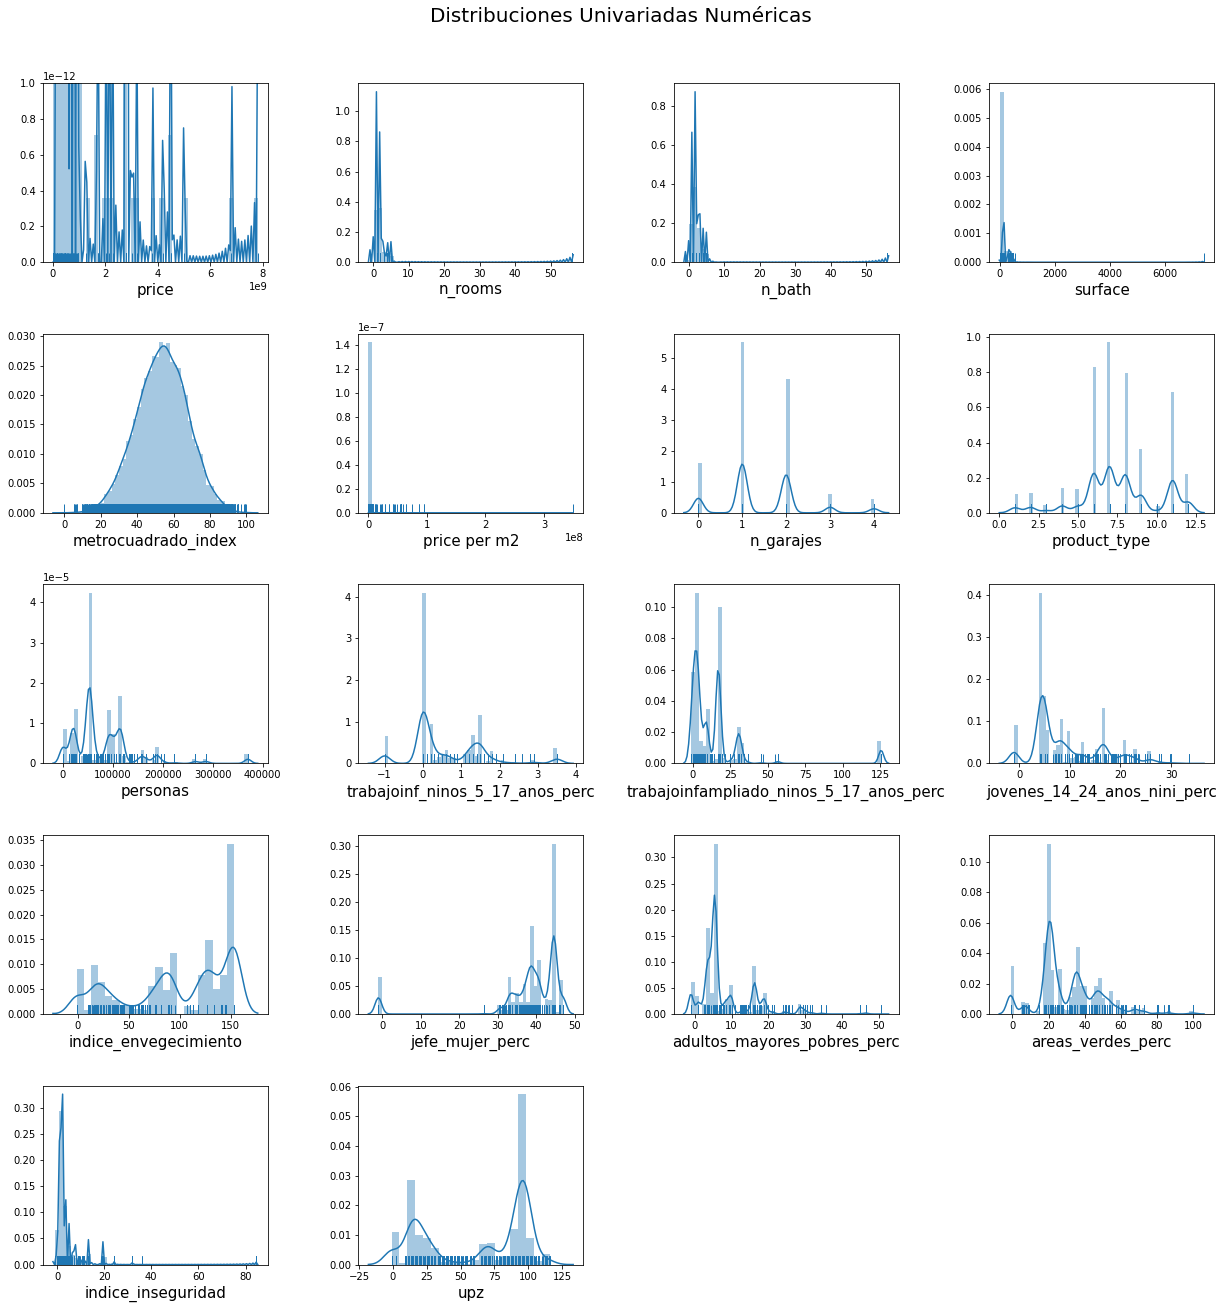

In [23]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=[17, 17])

# Se remueven los ultimos 2 plots
list(map(lambda a : a.remove(), ax[-1,-2:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)

#ax: lista de listas: fila i: [ax1 , ax2, ax3, ax4]
#ax.flatten : sacar la lista de listas y dejarla con una dimension -> lista de 24-1 elem
#len numeric=23

for axis, col in zip(ax.flatten(), numeric):
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.4, .4)
plt.subplots_adjust(wspace=w, hspace=h)

In [24]:
#caracter problematico
df[('categorical','zone')][2]='Fontiban'
df[('categorical','zone')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0           Teusaquillo
1                   NaN
2              Fontiban
3        Minuto de Dios
4               Toberin
              ...      
18009        Chico Lago
18010        Chico Lago
18011        Chico Lago
18012     Santa Barbara
18013        El Refugio
Name: (categorical, zone), Length: 18014, dtype: object

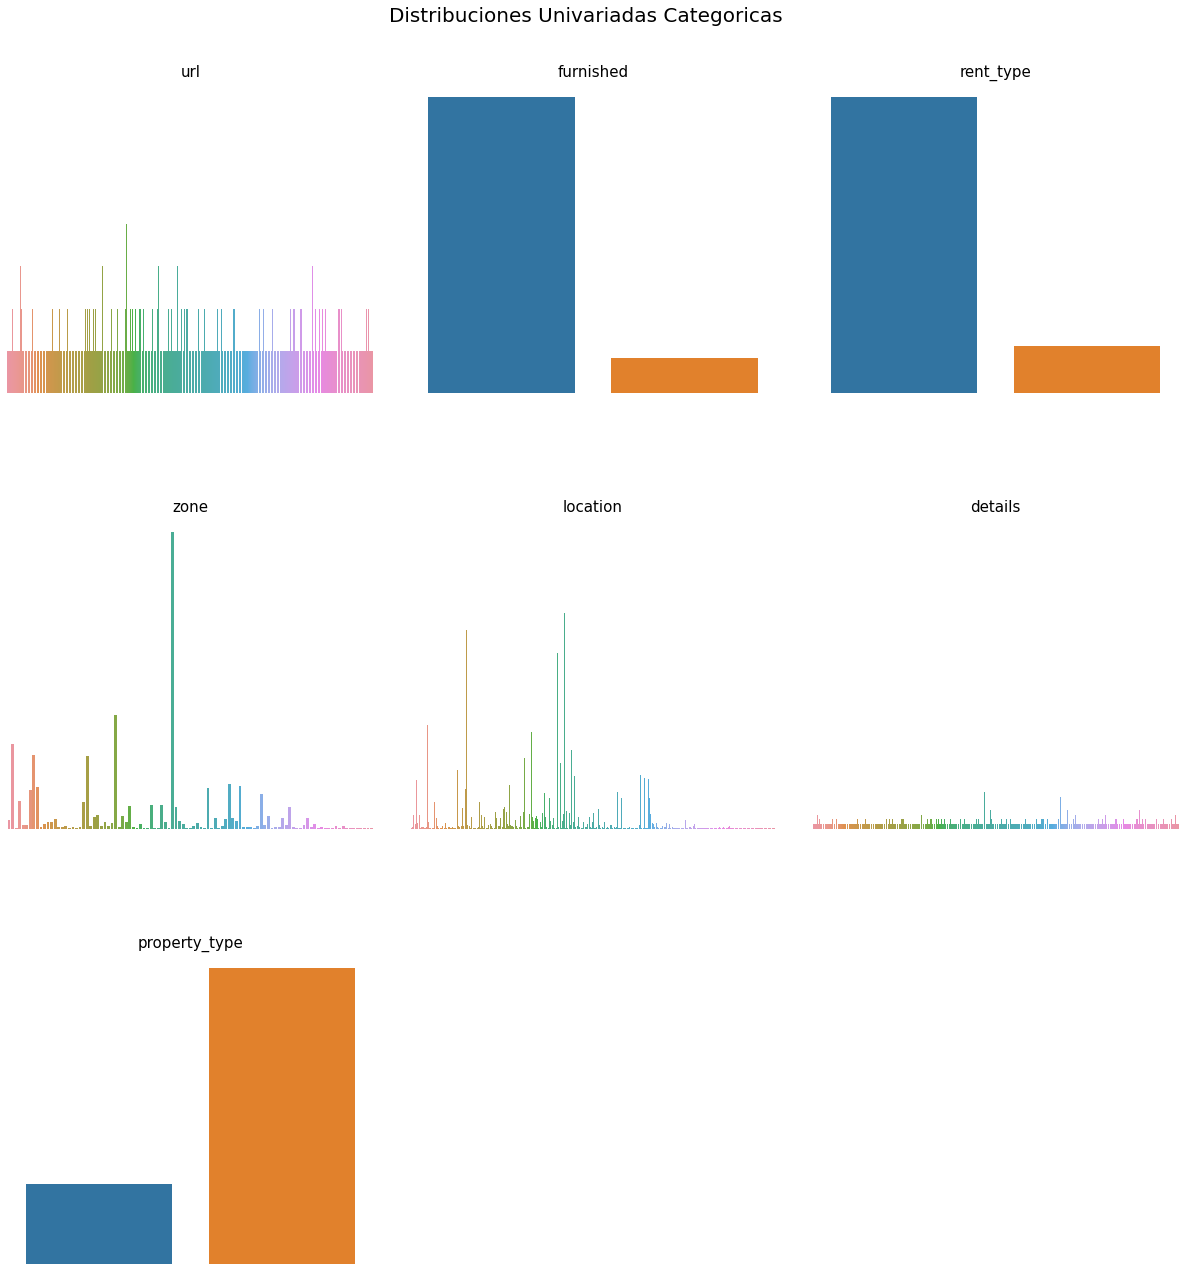

In [25]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[17, 17])


list(map(lambda a : a.remove(), ax[-1,-2:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Categoricas',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), categorical):

    # Graficos para datos tipos str
    sns.countplot(df[('categorical', col)], ax=axis)
    axis.set_axis_off()
    axis.set_title(col, fontsize=15)
  
    
# Se ajusta el espaciado interno entre subplots
h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)

### 3.Datos faltantes



In [26]:
df.replace(-1,NA, inplace = True) 
df

numeric  ...   categorical
           price  ... property_type
0      1050000.0  ...          Casa
1      3930000.0  ...          Casa
2       750000.0  ...          Casa
3      3400000.0  ...          Casa
4      1560000.0  ...          Casa
...          ...  ...           ...
18009  4620000.0  ...   Apartamento
18010  2700000.0  ...   Apartamento
18011  3600000.0  ...   Apartamento
18012  2525000.0  ...   Apartamento
18013  4600000.0  ...   Apartamento

[18014 rows x 25 columns]

In [0]:
df.replace('NaN',NA, inplace = True) 

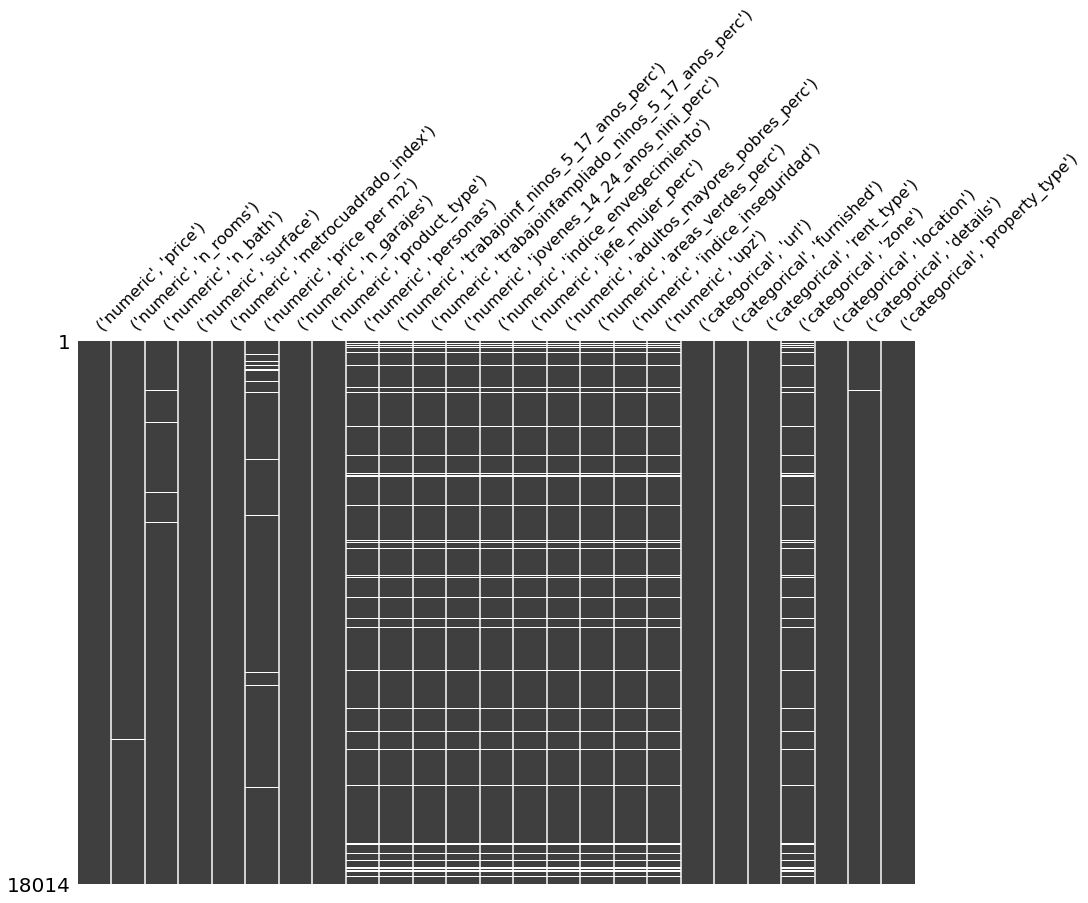

In [28]:
import missingno as msno
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(df,ax = ax, sparkline=False)

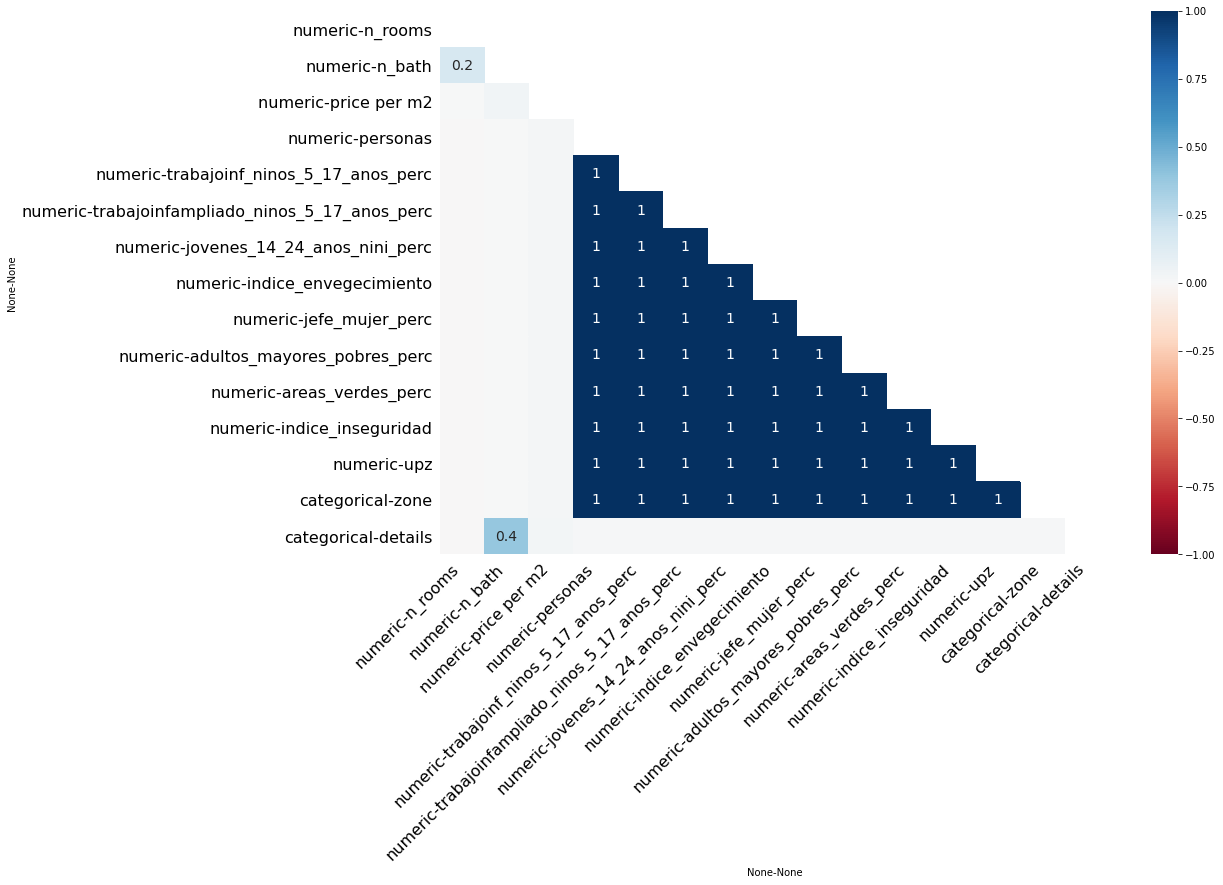

In [29]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df, ax = ax)

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Pipeline categorica
cat_pipe = Pipeline(
    steps=[('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')), 
           ('onehot',OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [0]:
num_pipe = Pipeline(steps=[('scaler', StandardScaler())])

In [0]:
#sin variable dependiente 'price per m2'
num = [
    'price', 'n_rooms', 'n_bath', 'surface',
    'metrocuadrado_index', 'n_garajes', 'product_type',
    'personas', 'trabajoinf_ninos_5_17_anos_perc', 'trabajoinfampliado_ninos_5_17_anos_perc',
    'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento', 'jefe_mujer_perc',
    'adultos_mayores_pobres_perc', 'areas_verdes_perc', 'indice_inseguridad', 'upz'
]

#sin variable url ni details
cat=[
     'furnished',
 'rent_type',
 'zone',
 'location',
 'property_type'
]

In [34]:
print(len(num) + len(cat))

22


In [0]:
#Preprocesador Compuesto
prep = ColumnTransformer(
    transformers=[('num', num_pipe, num), 
                  ('cat', cat_pipe, cat)])

In [36]:
# Variables regresoras
X = df.drop(['price per m2','url','details'], axis=1, level=1).copy()
print(X.shape)
# Variable dependiente
y = df[('numeric','price per m2')].copy()
print(y.shape)

(18014, 22)
(18014,)


In [0]:
X.columns = X.columns.droplevel(0)


In [0]:
X_prep = prep.fit_transform(X)

In [0]:
# Se obtienen las variables categoricas transformadas
post_cat = prep.named_transformers_['cat'][-1]
cat_cols_fit = post_cat.get_feature_names(cat)

In [42]:
# columnas del datase luego de transformarlo
post_cols = list(num) +list(cat_cols_fit) 
len(post_cols)

770

In [0]:
df_post = pd.DataFrame(data=X_prep, columns=post_cols)

In [44]:
df_post.shape

(18014, 770)

In [61]:
df_post[df_post.columns[0:17]]

,price,n_rooms,n_bath,surface,metrocuadrado_index,n_garajes,product_type,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,areas_verdes_perc,indice_inseguridad,upz
0,-0.058343,0.644773,-0.199527,-0.247756,-2.015582,-0.466140,0.567780,-1.022275,-0.112932,0.110157,-0.398407,0.923254,1.001529,-0.493732,-1.683482,-0.019850,0.970123
1,-0.036976,0.644773,-0.199527,0.101292,0.260132,-0.466140,-2.641630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.060569,0.644773,-0.844028,0.006955,-2.977555,-1.571598,-2.641630,1.482775,-0.340212,-0.605525,0.747636,-1.218204,-2.178085,0.865112,-0.683691,-0.698488,0.241276
3,-0.040908,1.913851,1.089477,-0.172286,0.166806,-1.571598,0.567780,1.117725,0.455267,-0.622169,0.449351,-0.669495,-0.803177,-0.053553,0.375516,-0.551532,-1.048223
4,-0.054560,1.279312,0.444975,0.063557,-0.472117,-0.466140,-2.641630,-0.544243,1.250746,0.039421,-0.100122,-1.019644,-0.986276,-0.474111,0.016440,-0.114495,-1.524777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18009,-0.031857,0.010234,0.444975,0.572978,0.138090,0.639317,1.771309,-0.498699,-0.794771,0.051903,-0.853684,1.087653,0.948835,-0.476721,-0.739947,-0.343221,0.857992
18010,-0.046102,0.010234,-0.199527,0.708258,-1.979687,-0.466140,1.771309,-0.498699,-0.794771,0.051903,-0.853684,1.087653,0.948835,-0.476721,-0.739947,-0.343221,0.857992
18011,-0.039425,0.010234,0.444975,0.195629,-0.206497,0.639317,0.166604,-0.498699,-0.794771,0.051903,-0.853684,1.087653,0.948835,-0.476721,-0.739947,-0.343221,0.857992
18012,-0.047400,0.010234,0.444975,0.157894,-0.665947,0.639317,0.166604,0.473009,0.909826,-0.572237,-0.712391,0.530404,-0.486988,-0.696681,-0.439546,-0.524549,-1.412647


In [45]:
from mcar import little_mcar
little_mcar(df_post)
#p>0.05 -> MCAR else MAR o MNAR

{'chi_stat': 45936504.24623824, 'deg_f': 17244, 'p_value': 0.0}

In [47]:
df_post.isnull().values.any()

True

In [0]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=8)

imputer_KNN = IterativeImputer(estimator=knn,
                              skip_complete=True,
                              verbose=1,
                              random_state=1)

In [49]:
df_post_array=imputer_KNN.fit_transform(df_post)

[IterativeImputer] Completing matrix with shape (18014, 770)
[IterativeImputer] Change: 6.862910226056307, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 5.048855330689915, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 3.440621617805416, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 2.500655240268732, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 2.5444070320229235, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 2.568736562881889, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 1.5226117637463645, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 1.3682638578720252, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 1.784696897091815, scaled tolerance: 0.06896747672402527 
[IterativeImputer] Change: 0.9738055019588481, scaled tolerance: 0.06896747672402527 


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [0]:
df_post_array=pd.DataFrame(df_post_array)

In [51]:
df_post_array.isnull().values.any()

False

In [64]:
df_post_array[df_post_array.columns[0:17]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.058343,0.644773,-0.199527,-0.247756,-2.015582,-0.466140,0.567780,-1.022275,-0.112932,0.110157,-0.398407,0.923254,1.001529,-0.493732,-1.683482,-0.019850,0.970123
1,-0.036976,0.644773,-0.199527,0.101292,0.260132,-0.466140,-2.641630,0.317521,-0.127137,-0.377713,0.154991,-0.786122,-0.905810,-0.112381,-0.281338,-0.484917,-0.901052
2,-0.060569,0.644773,-0.844028,0.006955,-2.977555,-1.571598,-2.641630,1.482775,-0.340212,-0.605525,0.747636,-1.218204,-2.178085,0.865112,-0.683691,-0.698488,0.241276
3,-0.040908,1.913851,1.089477,-0.172286,0.166806,-1.571598,0.567780,1.117725,0.455267,-0.622169,0.449351,-0.669495,-0.803177,-0.053553,0.375516,-0.551532,-1.048223
4,-0.054560,1.279312,0.444975,0.063557,-0.472117,-0.466140,-2.641630,-0.544243,1.250746,0.039421,-0.100122,-1.019644,-0.986276,-0.474111,0.016440,-0.114495,-1.524777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18009,-0.031857,0.010234,0.444975,0.572978,0.138090,0.639317,1.771309,-0.498699,-0.794771,0.051903,-0.853684,1.087653,0.948835,-0.476721,-0.739947,-0.343221,0.857992
18010,-0.046102,0.010234,-0.199527,0.708258,-1.979687,-0.466140,1.771309,-0.498699,-0.794771,0.051903,-0.853684,1.087653,0.948835,-0.476721,-0.739947,-0.343221,0.857992
18011,-0.039425,0.010234,0.444975,0.195629,-0.206497,0.639317,0.166604,-0.498699,-0.794771,0.051903,-0.853684,1.087653,0.948835,-0.476721,-0.739947,-0.343221,0.857992
18012,-0.047400,0.010234,0.444975,0.157894,-0.665947,0.639317,0.166604,0.473009,0.909826,-0.572237,-0.712391,0.530404,-0.486988,-0.696681,-0.439546,-0.524549,-1.412647


In [80]:
y_nan=y[y.isnull()]
y_nan


312     NaN
313     NaN
323     NaN
333     NaN
335     NaN
         ..
17510   NaN
17512   NaN
17522   NaN
17826   NaN
17916   NaN
Name: (numeric, price per m2), Length: 277, dtype: float64

In [81]:
price_nvo=df_post_array[0]
price_nvo

0       -0.058343
1       -0.036976
2       -0.060569
3       -0.040908
4       -0.054560
           ...   
18009   -0.031857
18010   -0.046102
18011   -0.039425
18012   -0.047400
18013   -0.032005
Name: 0, Length: 18014, dtype: float64

In [83]:
surface_nvo=df_post_array[3]
surface_nvo

0       -0.247756
1        0.101292
2        0.006955
3       -0.172286
4        0.063557
           ...   
18009    0.572978
18010    0.708258
18011    0.195629
18012    0.157894
18013    0.431472
Name: 3, Length: 18014, dtype: float64

In [86]:
price_per_m2_nvo=price_nvo.div(surface_nvo)
price_per_m2_nvo

0        0.235487
1       -0.365046
2       -8.708959
3        0.237445
4       -0.858434
           ...   
18009   -0.055599
18010   -0.065092
18011   -0.201527
18012   -0.300202
18013   -0.074177
Length: 18014, dtype: float64

### 4. UPZ clustering


In [66]:
df_upz=df_post_array[df_post_array.columns[16]]
df_upz

0        0.970123
1       -0.901052
2        0.241276
3       -1.048223
4       -1.524777
           ...   
18009    0.857992
18010    0.857992
18011    0.857992
18012   -1.412647
18013    0.605699
Name: 16, Length: 18014, dtype: float64

In [87]:
price_per_m2_nvo

0        0.235487
1       -0.365046
2       -8.708959
3        0.237445
4       -0.858434
           ...   
18009   -0.055599
18010   -0.065092
18011   -0.201527
18012   -0.300202
18013   -0.074177
Length: 18014, dtype: float64

Text(0, 0.5, 'price per m2')

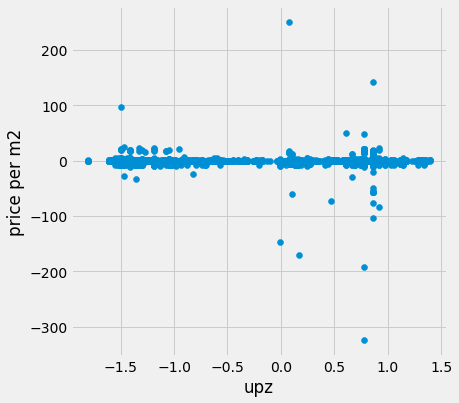

In [88]:
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')



# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(df_upz, price_per_m2_nvo)
plt.xlabel('upz')
plt.ylabel('price per m2')

In [89]:
df_concat=pd.concat([df_upz, price_per_m2_nvo], axis=1)
df_concat

,16,0
0,0.970123,0.235487
1,-0.901052,-0.365046
2,0.241276,-8.708959
3,-1.048223,0.237445
4,-1.524777,-0.858434
...,...,...
18009,0.857992,-0.055599
18010,0.857992,-0.065092
18011,0.857992,-0.201527
18012,-1.412647,-0.300202


Text(0.5, 1.0, 'Visualization of clustered data')

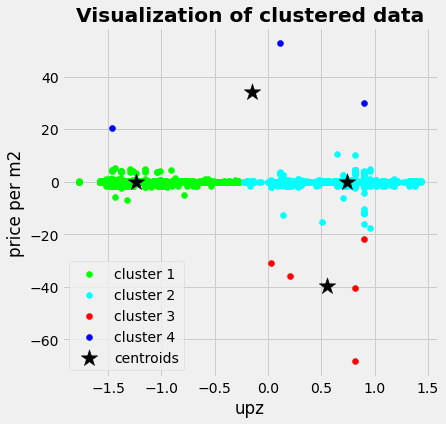

In [111]:
# Standardize the data
X_std = StandardScaler().fit_transform(df_concat)

# Run local implementation of kmeans
km = KMeans(n_clusters=4, max_iter=1000)
km.fit(X_std)
centroids = km.cluster_centers_

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            c='lime', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1],
            c='cyan', label='cluster 2')
plt.scatter(X_std[km.labels_ == 2, 0], X_std[km.labels_ == 2, 1],
            c='red', label='cluster 3')
plt.scatter(X_std[km.labels_ == 3, 0], X_std[km.labels_ == 3, 1],
            c='blue', label='cluster 4')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='black', label='centroids')
plt.legend()
plt.xlabel('upz')
plt.ylabel('price per m2')
plt.title('Visualization of clustered data', fontweight='bold')

In [112]:
from sklearn import metrics
metric=metrics.silhouette_score(X_std, km.labels_,
                                      metric='euclidean',
                                      sample_size=300)
metric           

0.7642713110857576

In [0]:
to_compare =['upz_cluster_1','upz_cluster_2','upz_cluster_3']
data_cat = df['categorical']

kwargs = {'index': data_cat[to_compare[0]], 'columns': data_cat[to_compare[1]]}

# Se construye la tabla
tabla = pd.crosstab(**kwargs, margins=True, margins_name='Total')
tabla

In [0]:
from scipy.stats import chi2_contingency

# Se debe trabajar la tabla sin margenes
tabla = pd.crosstab(**kwargs, margins=False)
print(tabla)
chi2, p, dof, ex =chi2_contingency(tabla)

### Relaciones entre variables


In [0]:
def indexer(cols, t_c = df.columns):
    '''Genera columnas multinivel a partir de nombres de columna planos.'''
    
    set_to_tuple = set(*[cols])

    tuples = [
        i for i in t_c if set_to_tuple.intersection(set(i))
    ]
    
    return tuples

In [0]:
interest = [
    'price', 'metrocuadrado_index', 'trabajoinf_ninos_5_17_anos_perc', 'trabajoinfampliado_ninos_5_17_anos_perc',
    'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento', 'price per m2'          
]

idxs = indexer(interest)

holi=df_post_array[df_post_array.columns[0:10]]

In [117]:
holi

,0,1,2,3,4,5,6,7,8,9
0,-0.058343,0.644773,-0.199527,-0.247756,-2.015582,-0.466140,0.567780,-1.022275,-0.112932,0.110157
1,-0.036976,0.644773,-0.199527,0.101292,0.260132,-0.466140,-2.641630,0.317521,-0.127137,-0.377713
2,-0.060569,0.644773,-0.844028,0.006955,-2.977555,-1.571598,-2.641630,1.482775,-0.340212,-0.605525
3,-0.040908,1.913851,1.089477,-0.172286,0.166806,-1.571598,0.567780,1.117725,0.455267,-0.622169
4,-0.054560,1.279312,0.444975,0.063557,-0.472117,-0.466140,-2.641630,-0.544243,1.250746,0.039421
...,...,...,...,...,...,...,...,...,...,...
18009,-0.031857,0.010234,0.444975,0.572978,0.138090,0.639317,1.771309,-0.498699,-0.794771,0.051903
18010,-0.046102,0.010234,-0.199527,0.708258,-1.979687,-0.466140,1.771309,-0.498699,-0.794771,0.051903
18011,-0.039425,0.010234,0.444975,0.195629,-0.206497,0.639317,0.166604,-0.498699,-0.794771,0.051903
18012,-0.047400,0.010234,0.444975,0.157894,-0.665947,0.639317,0.166604,0.473009,0.909826,-0.572237


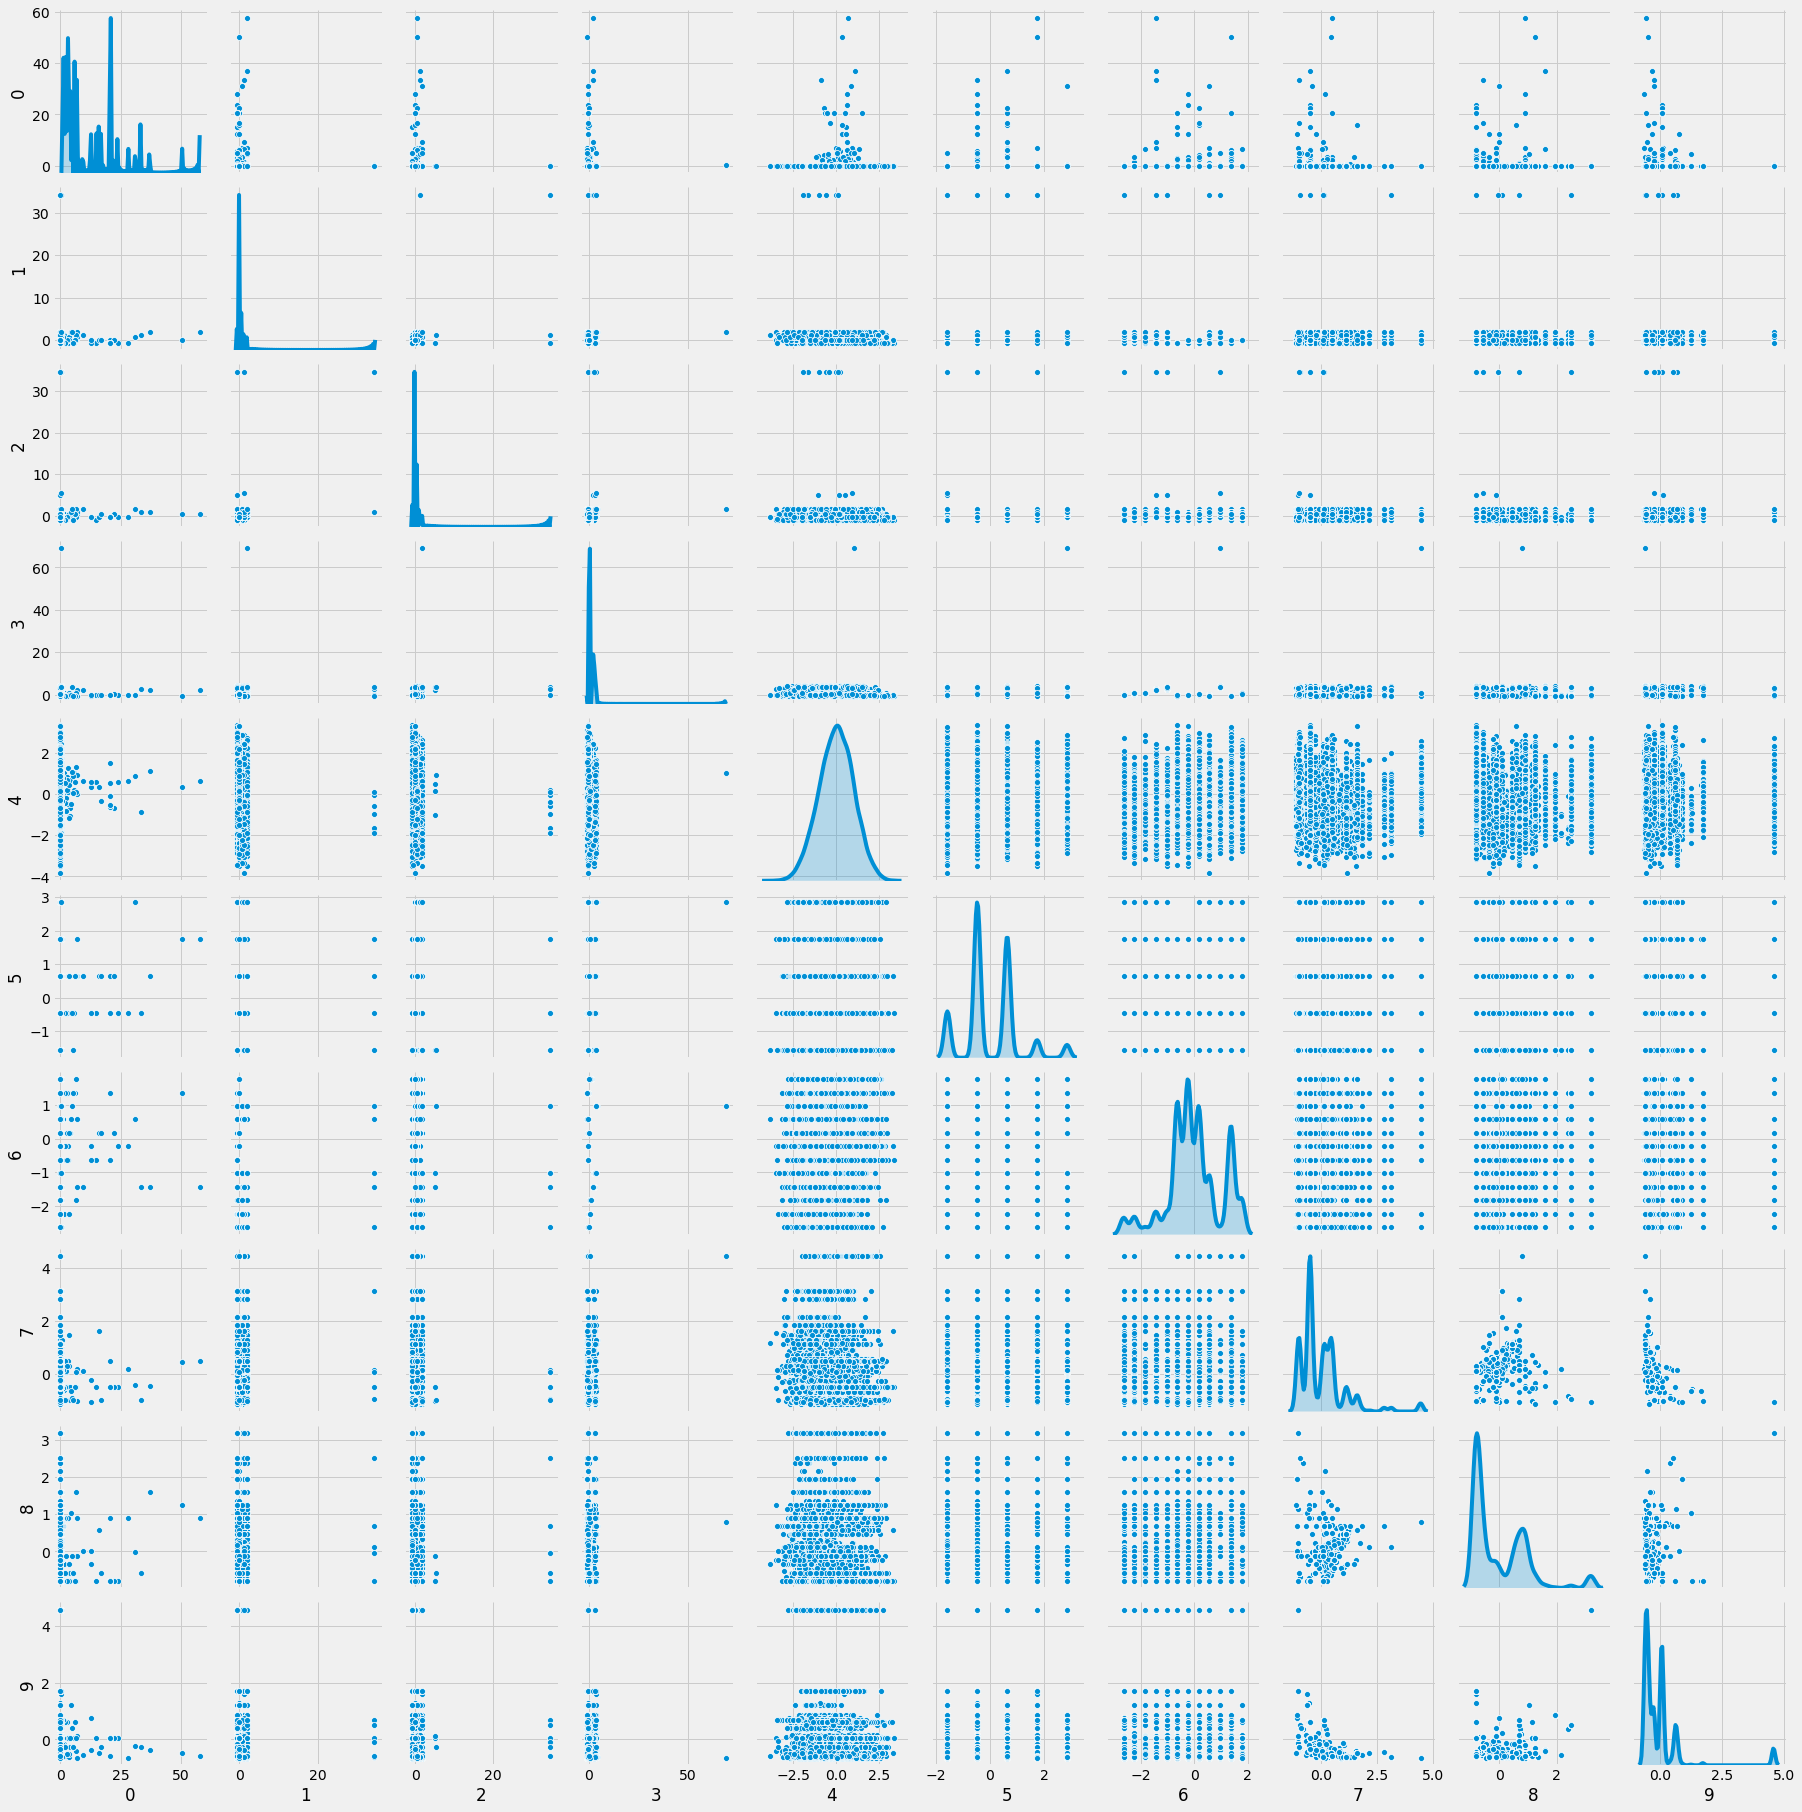

In [118]:
sns.pairplot(data = holi, diag_kind='kde')

In [105]:
corrmat = df.corr()
col = indexer(['price per m2'])
corrmat[col].nlargest(3,col)

numeric
                     price per m2
numeric price per m2     1.000000
        price            0.509425
        product_type     0.037305

In [106]:
corrmat[col].nsmallest(3,col)

numeric
                                                price per m2
numeric surface                                    -0.029682
        jovenes_14_24_anos_nini_perc               -0.010518
        trabajoinfampliado_ninos_5_17_anos_perc    -0.007820

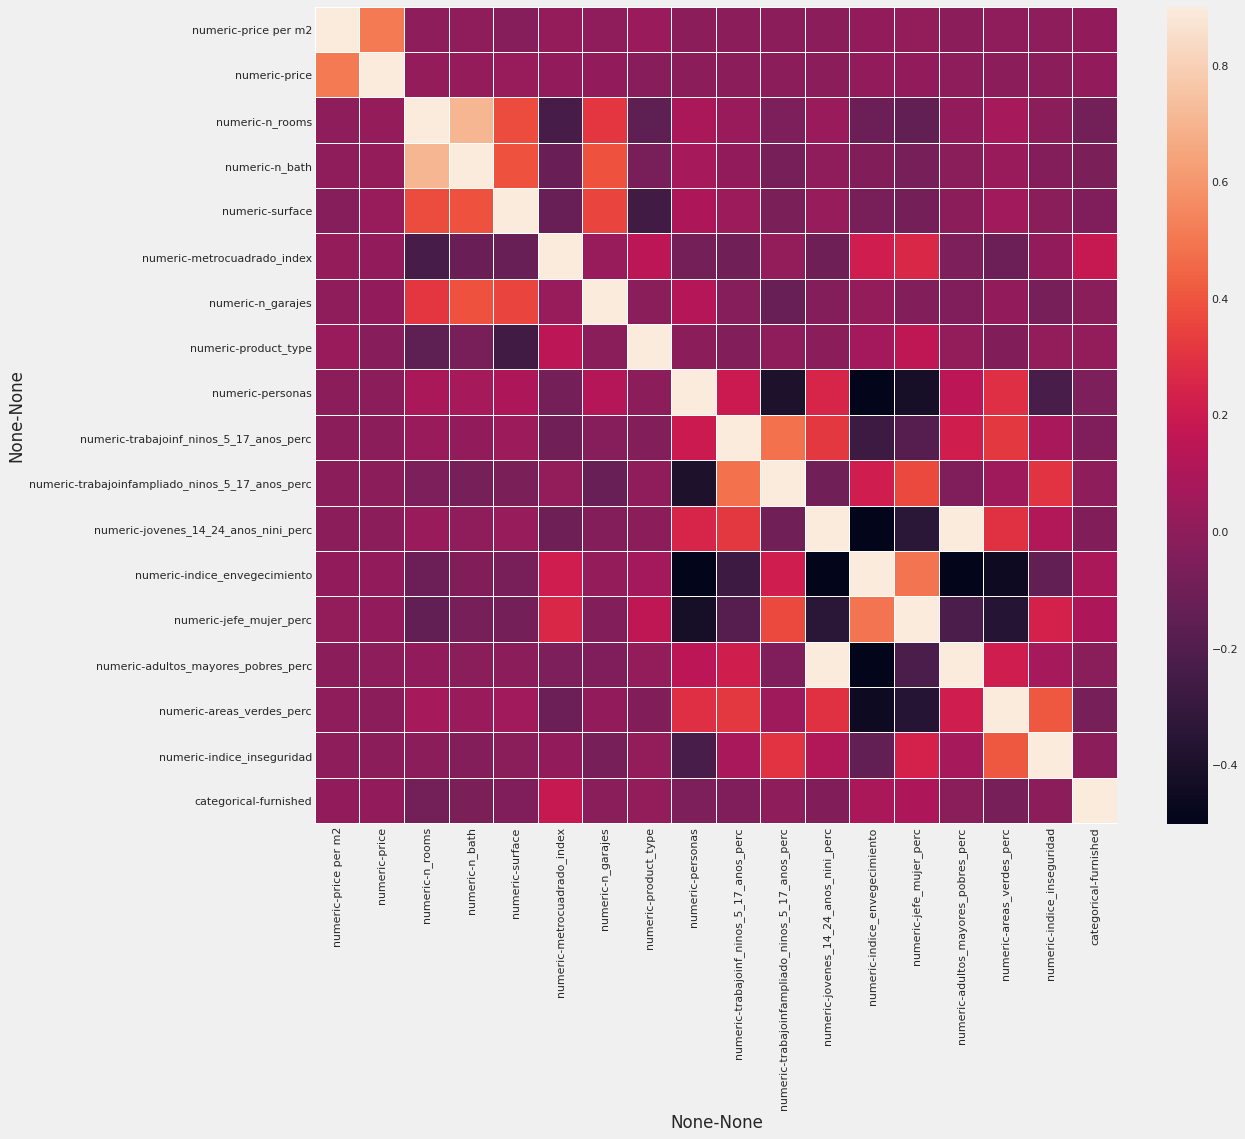

In [107]:
unsorted = list(corrmat.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corrmat.reindex(index = sortd, columns = sortd)
'''
Dado lo anterior, se ajusta el anchor de colores con maximo en .9
y -0.5, para tener una perspectiva entorno a los valores maximos 
de correlacion (negativa y positiva)
'''

fig, ax = plt.subplots(figsize=[16, 14])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

In [112]:
to_compare =['price per m2','product_type']
data_cat = df['numeric']

kwargs = {'index': data_cat[to_compare[0]], 'columns': data_cat[to_compare[1]]}

# Se construye la tabla
tabla = pd.crosstab(**kwargs, margins=True, margins_name='Total')
tabla


product_type,1,2,3,4,5,6,7,8,9,10,11,12,Total
price per m2,,,,,,,,,,,,,
0.0,0,1,0,0,0,0,0,0,1,1,0,0,3
1250.0,0,0,0,0,0,0,0,1,0,0,0,0,1
3543.4893617021276,0,0,0,0,0,0,0,0,0,1,0,0,1
4429.36170212766,0,0,0,0,0,0,0,0,0,0,0,1,1
4729.72972972973,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75000000.0,0,0,0,0,0,0,0,0,0,0,1,0,1
86666666.66666667,0,0,0,0,0,0,0,0,0,0,2,0,2
95000000.0,0,0,0,0,0,0,0,0,2,0,0,0,2


In [116]:
from scipy.stats import chi2_contingency

# Se debe trabajar la tabla sin margenes
tabla = pd.crosstab(**kwargs, margins=False)

chi2, p, dof, ex =chi2_contingency(tabla)
tabla

product_type,1,2,3,4,5,6,7,8,9,10,11,12
price per m2,,,,,,,,,,,,
0.000000e+00,0,1,0,0,0,0,0,0,1,1,0,0
1.250000e+03,0,0,0,0,0,0,0,1,0,0,0,0
3.543489e+03,0,0,0,0,0,0,0,0,0,1,0,0
4.429362e+03,0,0,0,0,0,0,0,0,0,0,0,1
4.729730e+03,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6.428571e+07,0,0,0,0,0,0,0,0,0,0,1,0
7.500000e+07,0,0,0,0,0,0,0,0,0,0,1,0
8.666667e+07,0,0,0,0,0,0,0,0,0,0,2,0


In [117]:
p

0.0